Use conda environment `conda_envs/hictk.yml` to run this notebook.

In [1]:
import hictkpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import itertools
from tqdm import tqdm
from multiprocessing import Pool


chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14',
       'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chrX'] + ['trans']

def process_loop(loop):
    a1, a2 = loop
    if loop[0] == loop[1]:
        return np.nan
    else:
        return sort_loop(loop)

def sort_loop(loop):
    a1, a2 = loop

    if chroms.index(a1[0]) > chroms.index(a2[0]):
        return (a2, a1)
    elif chroms.index(a1[0]) == chroms.index(a2[0]):
        if a1[1] > a2[1]:
            return (a2, a1)
        elif a1[1] == a2[1]:
            if a1[2] > a2[2]:
                return (a2, a1)
    return (a1, a2)

# Input data:

- `data/polycomb_dot_anchors.5kb.16_06_25.csv` - Polycomb anchors identified in this paper
- `/tank/projects/tian2023/mcools_fixed/*.mcool` - snm3C-seq data from *Tian et al., 2023* (“.tsv.gz” files were converted into “.cool” files using Cooler)
- `MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool` and `MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool` Hi-C maps aggregated from *Tian et al., 2023* snm3C-seq data

In [2]:
# data_dir = '/tank/projects/polycomb/data/'
data_dir = '../../data/'

polycomb_anchors_df = pd.read_csv(data_dir + 'polycomb_dot_anchors.5kb.16_06_25.csv')
polycomb_anchors_df['region'] = tuple(zip(polycomb_anchors_df.chrom, polycomb_anchors_df.start, polycomb_anchors_df.end))
polycomb_anchors_df['genes'] = polycomb_anchors_df['genes'].fillna('-')
polycomb_anchors = polycomb_anchors_df.set_index(['chrom', 'start','end']).index.to_list()

In [3]:
prefix = '/tank/projects/tian2023/mcools_fixed/'
lstdr = os.listdir(prefix)
mcools = {f: int(f.split('_cells')[0].split('years.')[1]) for f in lstdr if f.endswith('mcool')}
mcools = dict(sorted(mcools.items(), key=lambda item: item[1]))

In [4]:
mcool1 = 'MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool'
mcool2 = 'MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool'

mcool1 = prefix + mcool1+'::/resolutions/10000'
mcool2 = prefix + mcool2+'::/resolutions/10000'

# Generate candidates (all pairs)

In [8]:
potential_loops = list(itertools.product(polycomb_anchors, polycomb_anchors))
print('All new candidates to check:', len(polycomb_anchors))
assert len(potential_loops) == len(polycomb_anchors) * len(polycomb_anchors)

potential_loops_cis = list(set( [ l for l in potential_loops if l[0][0] == l[1][0]] ))
potential_loops_trans = list(set( [ l for l in potential_loops if l[0][0] != l[1][0]] ))

potential_loops_cis = [l for l in map(process_loop, potential_loops_cis) if l is not np.nan]
potential_loops_trans = [l for l in map(process_loop, potential_loops_trans) if l is not np.nan]
print(len(potential_loops_cis), 'cis and', len(potential_loops_trans), 'trans')

All new candidates to check: 262
4200 cis and 64182 trans


In [9]:
def to_ucsc(reg):
    return f'{reg[0]}:{reg[1]}-{reg[2]}'

def ext(reg, pad=10_000):
    return reg[0], reg[1] - pad, reg[2] + pad

def get_signal(clr, reg1, reg2):
    area = (reg1[2] - reg1[1])//10_000 * (reg2[2] - reg2[1])//10_000 
    signal = clr.fetch(to_ucsc(reg1), to_ucsc(reg2)).sum()
    return signal / area

def get_norm_signal(clr, reg1, reg2):
    reg = get_signal(clr, ext(reg1), ext(reg2))
    reg_with_bg = get_signal(clr, ext(reg1, 50_000), ext(reg2, 50_000))
    if reg_with_bg == 0:
        return 1
    return reg / reg_with_bg
    
def extract_loops(loops, cool_files):
    clrs = [hictkpy.File(f) for f in cool_files]
    data = {}

    for loop in tqdm(loops):
        loop = sort_loop(loop)
        reg1, reg2 = loop
        # signals = {clr: 2*get_signal(clr, ext(reg1), ext(reg2)) - get_signal(clr, ext(reg1, 30_000), ext(reg2, 30_000)) for clr in clrs}
        signals = {clr: get_norm_signal(clr, reg1, reg2) for clr in clrs}
        data[loop] = signals
    data = pd.DataFrame(data)
    return data

# Identify cis-loops

In [10]:
potential_loops_cis_data = extract_loops(potential_loops_cis, (mcool1, mcool2))

100%|██████████| 4200/4200 [06:16<00:00, 11.16it/s]


Of 4200 cis candidates found 1605 cis loops


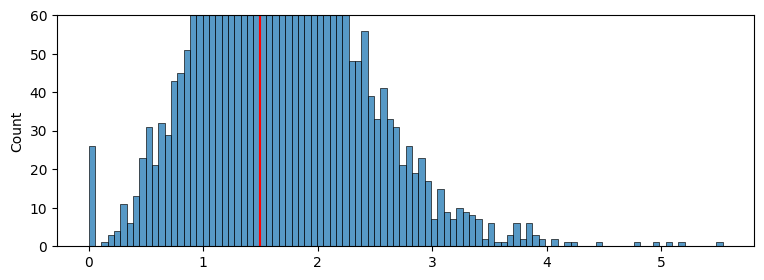

In [11]:
plt.figure(figsize=(9, 3))

potential_loops_cis_data_np = potential_loops_cis_data.to_numpy().ravel() 
sns.histplot(potential_loops_cis_data_np, bins=100)

lim = 1.5
plt.ylim(0, 60)
plt.axvline(lim, c='r')

found_loops = potential_loops_cis_data.T[potential_loops_cis_data.gt(lim).any(axis=0)]

print('Of', len(potential_loops_cis_data_np), 'cis candidates found', len(found_loops), 'cis loops')

## Prepare and save loops

In [12]:
found_loops = potential_loops_cis_data.T[potential_loops_cis_data.gt(lim).any(axis=0)]

found_loops_df = pd.DataFrame(list(found_loops.index), columns=['region1', 'region2'])
found_loops_df[['chrom1', 'start1', 'end1']] = found_loops_df['region1'].apply(pd.Series)
found_loops_df[['chrom2', 'start2', 'end2']] = found_loops_df['region2'].apply(pd.Series)
found_loops_df['contact_pair'] = tuple(zip(found_loops_df.region1, found_loops_df.region2))
found_loops_df['dist_from_diag'] = np.abs((found_loops_df['start2'] + found_loops_df['end2'])/2 - (found_loops_df['start1'] + found_loops_df['end1'])/2 )
found_loops_df['pixel_size'] = (found_loops_df['end2'] -found_loops_df['start2']) * (found_loops_df['end1'] - found_loops_df['start1'])

# add gene annotation
found_loops_df = found_loops_df.merge(polycomb_anchors_df[['region', 'genes']], how='left',
                                    left_on='region1', right_on='region').rename({'genes':'gene1'}, axis=1)
found_loops_df = found_loops_df.merge(polycomb_anchors_df[['region', 'genes']], how='left',
                                    left_on='region2', right_on='region').rename({'genes':'gene2'}, axis=1)
found_loops_df = found_loops_df.drop(columns=['region_x', 'region_y'])
#found_loops_df[['gene1', 'gene2']] = found_loops_df[['gene1', 'gene2']].fillna('!')

In [13]:
found_loops_df = found_loops_df.query('dist_from_diag > 3_000_000')

In [14]:
found_loops_df.to_csv(data_dir + 'polycomb_dots_hand_coords_update_June25.tsv', sep='\t')
print(len(found_loops_df))
found_loops_df.head(3)

1513


,region1,region2,chrom1,start1,end1,chrom2,start2,end2,contact_pair,dist_from_diag,pixel_size,gene1,gene2
0,"(chr2, 72910000, 72920000)","(chr2, 236155000, 236185000)",chr2,72910000,72920000,chr2,236155000,236185000,"((chr2, 72910000, 72920000), (chr2, 236155000,...",163255000.0,300000000,EMX1,"GBX2,AC019068.1"
1,"(chr4, 80260000, 80270000)","(chr4, 84475000, 84515000)",chr4,80260000,80270000,chr4,84475000,84515000,"((chr4, 80260000, 80270000), (chr4, 84475000, ...",4230000.0,400000000,FGF5,NKX6-1
2,"(chr2, 72140000, 72150000)","(chr2, 174320000, 174350000)",chr2,72140000,72150000,chr2,174320000,174350000,"((chr2, 72140000, 72150000), (chr2, 174320000,...",102190000.0,300000000,CYP26B1,"SP9,LINC01305,AC018470.1"
